In [1]:
# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
raw_data = pd.read_csv("Train_data.csv")
raw_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Preprocessing

In [4]:
raw_data["Loan_Status"].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
data = raw_data.copy()

In [7]:
# select numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# initialize imputer class to use strategy mean
imputer_N = SimpleImputer(strategy="mean")
imputer_N.fit(data[numeric_columns])

# fill missing data
data[numeric_columns] = imputer_N.transform(data[numeric_columns])

In [8]:
# select categorical columns
categorical_columns = data.drop(columns=["Loan_Status"]).select_dtypes(include=['object']).columns.tolist()

# initialize imputer class to use strategy mode
imputer_C = SimpleImputer(strategy="most_frequent")
imputer_C.fit(data[categorical_columns])

# fill missing data
data[categorical_columns] = imputer_C.transform(data[categorical_columns])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


In [10]:
# select categorical columns
categorical_columns = data.drop(columns=["Loan_ID", "Loan_Status"]).select_dtypes(include=['object']).columns.tolist()

encoder = OrdinalEncoder()
encoder.fit(data[categorical_columns])

#transforming categorical data into numerical for processing
data[categorical_columns] = encoder.transform(data[categorical_columns])

In [11]:
data[categorical_columns].head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,1.0,0.0,0.0,0.0,0.0,2.0
1,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,2.0
3,1.0,1.0,0.0,1.0,0.0,2.0
4,1.0,0.0,0.0,0.0,0.0,2.0


In [12]:
# no duplicates
data.duplicated().sum()

0

In [13]:
numeric_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

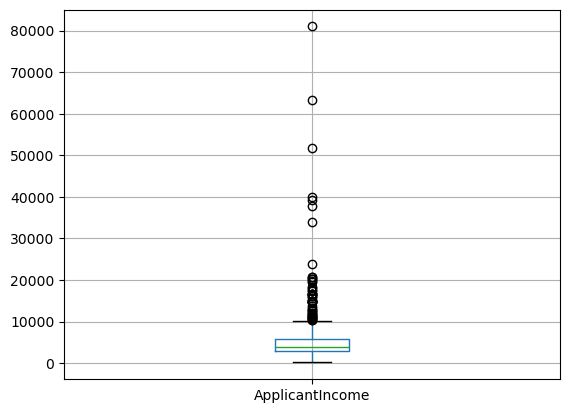

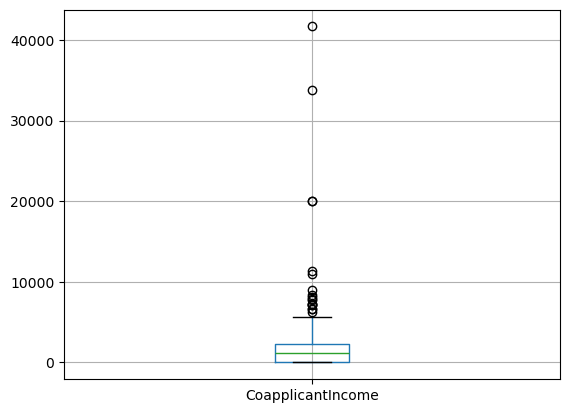

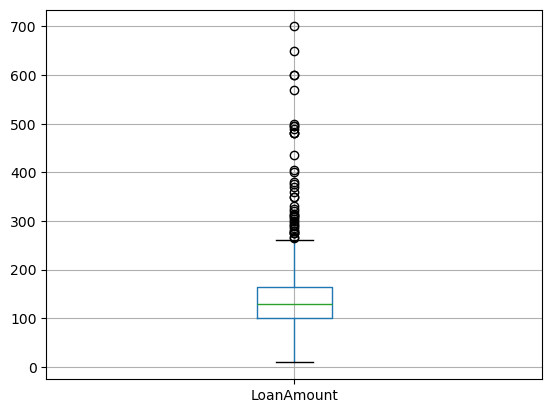

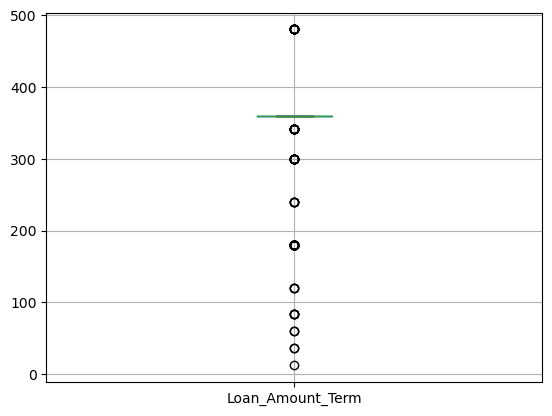

In [14]:
# check outliers

# select numeric columns
numeric_columns = [
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
]

for column in numeric_columns:
    plt.figure()
    data.boxplot(column=[column])

plt.show()

In [15]:
# remove outlier for each column

print("Data shape before removing outliers", data.shape)

for column in numeric_columns:
    # Calculate Q1, Q3, and IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter DataFrame to remove outliers
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

print("Data shape after removing outliers", data.shape)

Data shape before removing outliers (614, 13)
Data shape after removing outliers (431, 13)


## Classification

In [16]:
X = data.drop(columns=["Loan_ID", "Loan_Status"])
Y = data["Loan_Status"].replace({"Y": 1, "N": 0})

print(X.shape, Y.shape)

(431, 11) (431,)


In [17]:
# classification 1 : K Nearest Neighbours
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X, Y)

KNeighborsClassifier()

In [18]:
# predicitng Y based on X
y_pred = classifier.predict(X)

#  investigate the performance of classifier 
score = accuracy_score(Y, y_pred)
print("Accuracy Score:", score)

Accuracy Score: 0.7633410672853829


In [19]:
#classification 2 : Decisison Tree
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X, Y)

DecisionTreeClassifier(max_depth=3)

In [20]:
# predicitng X based on Y
y_pred = classifier.predict(X)

#  investigate the performance of classifier 
score = accuracy_score(Y, y_pred)
print("Accuracy Score:", score)

Accuracy Score: 0.839907192575406


In [21]:
#comparing accuracy --> Decision tree is better 

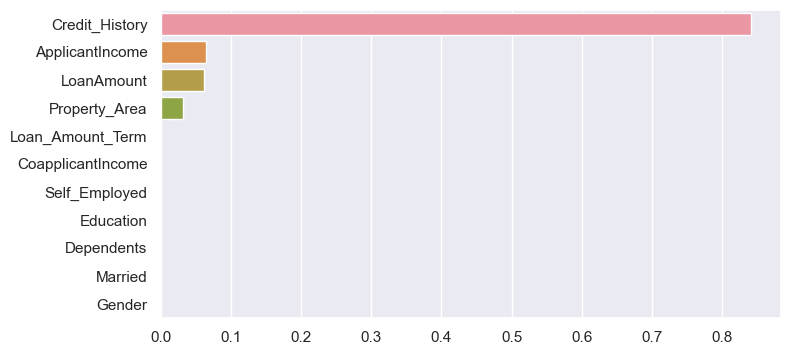

In [22]:
# Sort the feature importances from greatest to least using the sorted indices
feature_importances = classifier.feature_importances_

sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(8, 4)})
sns.barplot(x=sorted_importances, y=sorted_feature_names);

# Testing

In [23]:
RawData_NewCustomer = pd.read_csv("New_Customer.csv")
RawData_NewCustomer.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [24]:
RawData_NewCustomer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [25]:
Data_NewCustomer= RawData_NewCustomer.copy()

In [26]:
# select numeric columns
numeric_columns = Data_NewCustomer.select_dtypes(include=[np.number]).columns.tolist()

# fill missing data
Data_NewCustomer[numeric_columns] = imputer_N.transform(Data_NewCustomer[numeric_columns])

In [27]:
# select categorical columns
categorical_columns = Data_NewCustomer.select_dtypes(include=['object']).columns.tolist()

# fill missing data
Data_NewCustomer[categorical_columns] = imputer_C.transform(Data_NewCustomer[categorical_columns])

In [28]:
Data_NewCustomer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             367 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         367 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      367 non-null    object 
 6   ApplicantIncome    367 non-null    float64
 7   CoapplicantIncome  367 non-null    float64
 8   LoanAmount         367 non-null    float64
 9   Loan_Amount_Term   367 non-null    float64
 10  Credit_History     367 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(5), object(7)
memory usage: 34.5+ KB


In [29]:
# select categorical columns
categorical_columns = Data_NewCustomer.drop(columns=["Loan_ID"]).select_dtypes(include=['object']).columns.tolist()

#transforming categorical data into numerical for processing
Data_NewCustomer[categorical_columns] = encoder.transform(Data_NewCustomer[categorical_columns])

In [30]:
Data_NewCustomer[categorical_columns].head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,1.0,1.0,0.0,0.0,0.0,2.0
1,1.0,1.0,1.0,0.0,0.0,2.0
2,1.0,1.0,2.0,0.0,0.0,2.0
3,1.0,1.0,2.0,0.0,0.0,2.0
4,1.0,0.0,0.0,1.0,0.0,2.0


In [31]:
# prediticon loans on new data
X_test = Data_NewCustomer.drop(columns=["Loan_ID"])
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [32]:
# Predicitng loan status (adding it in the table), making it's format categorical for presentation 
raw_data_analysis = RawData_NewCustomer.copy()
raw_data_analysis["Loan_Status_Predict"] = classifier.predict(X_test)
raw_data_analysis["Loan_Status_Predict"] = raw_data_analysis["Loan_Status_Predict"].replace({1: "Y", 0: "N"})

raw_data_analysis.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status_Predict
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,Y
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,Y


# Percentage workout 

In [33]:
raw_data_analysis["Loan_Status_Predict"].value_counts()

Loan_Status_Predict
Y    294
N     73
Name: count, dtype: int64

In [34]:
raw_data_analysis["Property_Area"].value_counts()

Property_Area
Urban        140
Semiurban    116
Rural        111
Name: count, dtype: int64

In [35]:
raw_data_analysis["Married"].value_counts()

Married
Yes    233
No     134
Name: count, dtype: int64

In [36]:
# filtering data to get only the ones accepted, show only marital status & property area 
mask = raw_data_analysis["Loan_Status_Predict"] == "Y"
analysis = raw_data_analysis[mask].groupby(["Married", "Property_Area"]).size().reset_index(name="Loan_Accepted")

analysis["percentage"] = analysis["Loan_Accepted"] / raw_data_analysis[mask].shape[0]

analysis

,Married,Property_Area,Loan_Accepted,percentage
0,No,Rural,31,0.105442
1,No,Semiurban,35,0.119048
2,No,Urban,40,0.136054
3,Yes,Rural,56,0.190476
4,Yes,Semiurban,56,0.190476
5,Yes,Urban,76,0.258503


In [37]:
# percentage of married people in semiurban area that obtained the loan
# percentage = 19.04% 

In [38]:
##Thank you## 